In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import requests
from math import floor
from termcolor import colored as cl
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
df = pd.read_csv('Google_Stock_Price_Train.csv')
df

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [3]:
def get_historical_data(symbol, start_date = None):
    api_key = 'GZ5XPUCXEDPE6PCL'
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

googl = get_historical_data('GOOGL', '2000-01-01')
googl

,open,high,low,close,adj close,volume
2004-08-19,100.01,104.06,95.960,100.335,2.516142,44659000.0
2004-08-20,101.01,109.08,100.500,108.310,2.716134,22834300.0
2004-08-23,110.76,113.48,109.050,109.400,2.743469,18256100.0
2004-08-24,111.24,111.60,103.570,104.870,2.629868,15247300.0
2004-08-25,104.76,108.00,103.880,106.000,2.658206,9188600.0
...,...,...,...,...,...,...
2023-02-06,102.40,104.36,101.880,102.900,102.900000,31999562.0
2023-02-07,103.22,108.18,103.120,107.640,107.640000,49010230.0
2023-02-08,102.05,103.14,98.035,99.370,99.370000,94743515.0
2023-02-09,100.00,100.03,93.630,95.010,95.010000,119455020.0


# Indicators

In [4]:
#Moving average
def movAverage(data, period=30, column='open'):
    return data[column].rolling(window=period).mean()

googl['moving_Avg_10'] = movAverage(googl,10)
googl['moving_Avg_50'] = movAverage(googl,50)
#googl = googl.dropna()

In [6]:
googl

,open,high,low,close,adj close,volume,moving_Avg_10,moving_Avg_50
2004-08-19,100.01,104.06,95.960,100.335,2.516142,44659000.0,NaN,NaN
2004-08-20,101.01,109.08,100.500,108.310,2.716134,22834300.0,NaN,NaN
2004-08-23,110.76,113.48,109.050,109.400,2.743469,18256100.0,NaN,NaN
2004-08-24,111.24,111.60,103.570,104.870,2.629868,15247300.0,NaN,NaN
2004-08-25,104.76,108.00,103.880,106.000,2.658206,9188600.0,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-02-06,102.40,104.36,101.880,102.900,102.900000,31999562.0,99.167,93.771626
2023-02-07,103.22,108.18,103.120,107.640,107.640000,49010230.0,99.679,93.894226
2023-02-08,102.05,103.14,98.035,99.370,99.370000,94743515.0,100.327,93.970426
2023-02-09,100.00,100.03,93.630,95.010,95.010000,119455020.0,100.677,94.029700


In [7]:
#RSI
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

googl['rsi_14'] = get_rsi(googl['open'], 14)
googl = googl.dropna()
googl

,open,high,low,close,adj close,volume,moving_Avg_10,moving_Avg_50,rsi_14
2004-10-28,186.63,194.39,185.600,193.30,4.847464,29663900.0,163.2943,126.044540,80.478953
2004-10-29,198.87,199.95,190.600,190.64,4.780758,42282600.0,168.6863,128.021740,83.567915
2004-11-01,193.50,197.67,191.270,196.03,4.915925,24425300.0,173.7243,129.871540,77.754735
2004-11-02,198.73,199.25,193.340,194.87,4.886835,22669900.0,178.5473,131.630940,79.267391
2004-11-03,198.19,201.60,190.750,191.67,4.806587,27749600.0,183.5723,133.369940,78.672548
...,...,...,...,...,...,...,...,...,...
2023-02-06,102.40,104.36,101.880,102.90,102.900000,31999562.0,99.1670,93.771626,63.437523
2023-02-07,103.22,108.18,103.120,107.64,107.640000,49010230.0,99.6790,93.894226,64.629465
2023-02-08,102.05,103.14,98.035,99.37,99.370000,94743515.0,100.3270,93.970426,61.546426
2023-02-09,100.00,100.03,93.630,95.01,95.010000,119455020.0,100.6770,94.029700,56.463982


In [113]:
#rsi(14, googl)

In [7]:
def ema(data, window):
    weights = 2 / (window + 1)
    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append(weights * data[i] + (1 - weights) * ema[-1])
    return ema

In [8]:
len(ema(googl['open'],2))

1538

In [9]:
def macd(data, window_fast, window_slow):
    ema_fast = ema(data, window_fast)
    ema_slow = ema(data, window_slow)
    macd = [ema_fast[i] - ema_slow[i] for i in range(len(data))]
    return macd

In [10]:
macd(googl['open'], 2, 5)

[0.0,
 3.089999999999918,
 2.293333333333294,
 4.103333333333239,
 7.387037037036862,
 6.708518518518304,
 4.916954732510021,
 4.012839506172554,
 3.7935162322814904,
 2.568440786465203,
 1.6587705126248693,
 0.821339226743703,
 0.48272355727146987,
 1.1402037291061333,
 6.156265160823523,
 8.09288655435546,
 8.558160963061255,
 6.7430750620933395,
 -2.4720718185869828,
 -9.823866276830017,
 -7.774516983810713,
 -8.591435588959598,
 -4.153765148112825,
 -2.9812239061218406,
 -0.5314983176523356,
 1.8076625503747437,
 2.3257732876307955,
 2.3307371653252176,
 3.397231990296177,
 3.569290398001499,
 2.49434995571346,
 1.597840978379736,
 1.980207654887863,
 3.8517985485812005,
 3.415085736383844,
 3.5857971700324924,
 1.6835558952803922,
 -0.013287920282323284,
 0.41258854743318807,
 1.7588747519403114,
 3.310521741399498,
 0.4629940187461443,
 -0.9660108126761315,
 -0.9355650390641586,
 1.2324373637527515,
 1.630340705766912,
 4.359799069377232,
 3.3741678014291665,
 3.378656897122937,


# Strategy

In [8]:
#Moving average strategy
def movingAvg(ma):
    t = []
    buy_price = []
    for i in range(len(ma)):
        if ma[i] - googl['open'][i] > 0.01*googl['open'][i]:
            t.append(1)
            buy_price.append(googl['open'][i])
        else:
            t.append(0)
            buy_price.append(np.nan)
    return t, buy_price
mv, buy_price = movingAvg(googl['moving_Avg_50'])
#len(googl)
buy_price

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 182.2,
 179.27,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 186.66,
 186.08,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 183.37,
 189.15,
 186.0,
 189.29,
 185.95,
 186.13,
 186.7,
 187.78,
 189.1,
 184.21,
 181.01,
 180.44,
 178.33,
 175.25,
 176.7,
 177.13,
 178.81,
 179.27,
 181.18,
 177.97,
 180.228,
 181.68,
 181.05,
 180.64,
 177.95,
 181.76,
 179.95,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 184.58,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 n

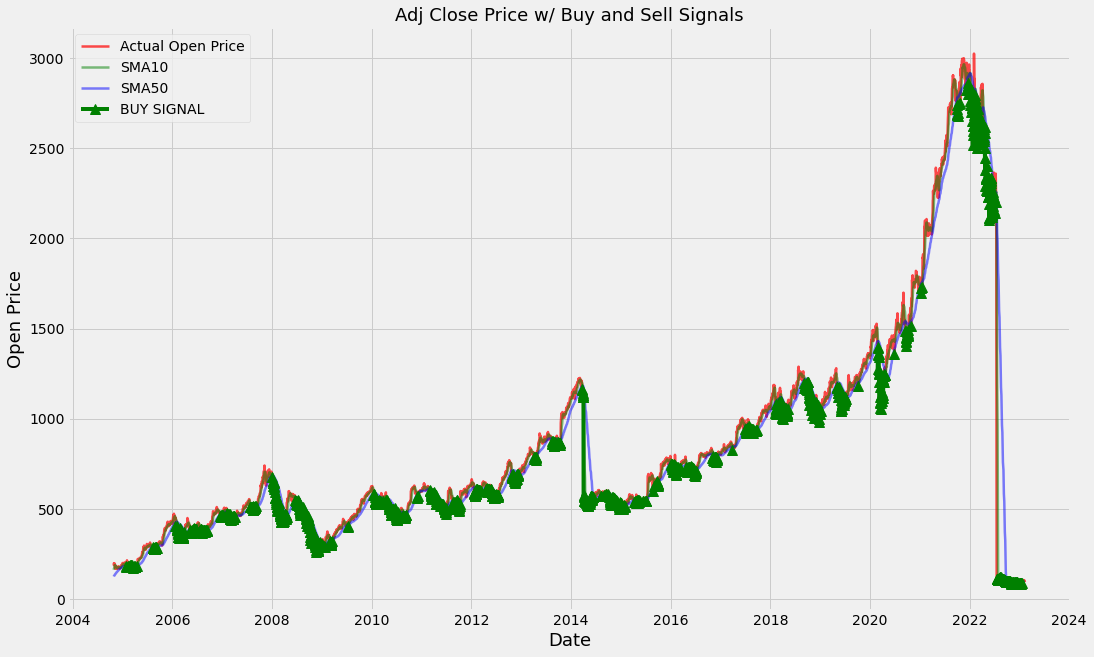

In [9]:
#moving_Avg = movAverage(20)
#moving_Avg1 = movAverage(50)
plt.figure(figsize=(16,10))
plt.plot(googl['open'], color="r",alpha=0.7, linewidth = 2.5,label='Actual Open Price')
plt.plot(googl['moving_Avg_10'],color="g", alpha=0.5, linewidth = 2.5, label='SMA10')
plt.plot(googl['moving_Avg_50'],color="b", alpha=0.5, linewidth = 2.5, label='SMA50')
plt.plot(googl.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')

# Adding text into the visualization
plt.title('Adj Close Price w/ Buy and Sell Signals', fontsize=18)
plt.ylabel('Open Price', fontsize=18)
plt.xlabel('Date', fontsize=18)

# Give legend
plt.legend()

# Show the graph
plt.show()

In [114]:
#RSI strategy
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(googl['close'], googl['rsi_14'])
rsi_signal

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,

In [117]:
#RSI(rsi(14,googl))
googl

,open,high,low,close,adj close,volume,moving_Avg_10,moving_Avg_50,rsi_14
2021-03-16,2065.99,2113.680,2059.2900,2083.89,104.1945,1595015.0,2056.8774,1954.916992,55.744729
2021-03-17,2068.47,2099.000,2044.1218,2082.22,104.1110,1319126.0,2058.5294,1961.086392,56.108743
2021-03-18,2048.18,2068.746,2019.1800,2021.34,101.0670,1585648.0,2061.8605,1967.548192,52.317231
2021-03-19,2029.73,2037.040,2002.9300,2026.96,101.3480,2303596.0,2058.7185,1974.137692,49.070114
2021-03-22,2027.63,2048.340,2014.0000,2030.69,101.5345,1676771.0,2053.0755,1980.155092,48.699616
...,...,...,...,...,...,...,...,...,...
2023-02-06,102.40,104.360,101.8800,102.90,102.9000,31999562.0,99.1670,93.771626,63.437523
2023-02-07,103.22,108.180,103.1200,107.64,107.6400,49010230.0,99.6790,93.894226,64.629465
2023-02-08,102.05,103.140,98.0350,99.37,99.3700,94743515.0,100.3270,93.970426,61.546426
2023-02-09,100.00,100.030,93.6300,95.01,95.0100,119455020.0,100.6770,94.029700,56.463982


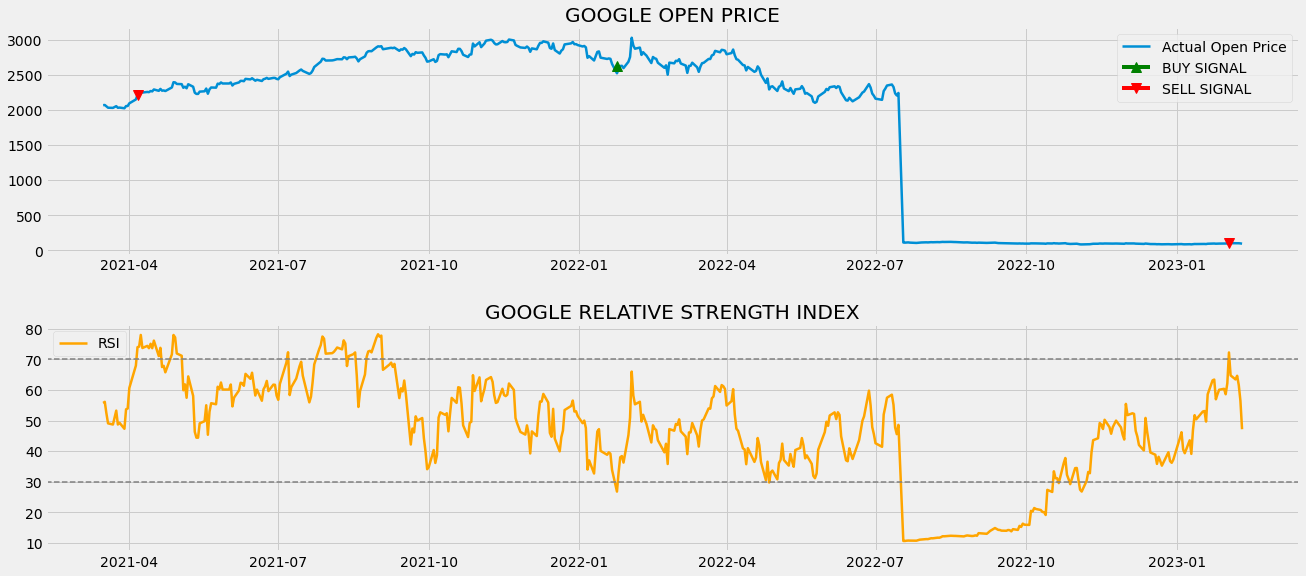

In [129]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(googl['open'], linewidth = 2.5, label= 'Actual Open Price')
ax1.plot(googl.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(googl.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('GOOGLE OPEN PRICE')
ax2.plot(googl['rsi_14'], color = 'orange', linewidth = 2.5, label='RSI')
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('GOOGLE RELATIVE STRENGTH INDEX')
# Give legend
ax1.legend()
ax2.legend()

plt.show()

In [51]:
#EMA Strategy
def ema_strategy(data, window_fast, window_slow):
    ema_fast = ema(data, window_fast)
    ema_slow = ema(data, window_slow)
    signals = []
    for i in range(len(data)):
        if ema_fast[i] > ema_slow[i]:
            signals.append(1)
        else:
            signals.append(0)
    return signals

In [63]:
len(ema_strategy(googl['open'], 3, 5))

1538

In [133]:
def macd_strategy(data, window_fast, window_slow, signal_window):
    macdd = macd(data, window_fast, window_slow)
    signal = ema(macdd, signal_window)
    signals = []
    for i in range(len(data)):
        if macdd[i] > signal[i]:
            signals.append(1)
        else:
            signals.append(0)
    return signals

In [135]:
len(macd_strategy(googl['open'], 3, 5, 2))

1538

# Training

Moving Average

In [53]:
def dataSplit(X, t):
    split_percentage = 0.8
    split = int(split_percentage*len(df))

    #Train data set
    X_train = X[:split]
    y_train = t[:split]

    #Teset data set
    X_test = X[split:]
    y_test = t[split:]
    return X_train, X_test, y_train, y_test

Support Vector Machine

In [54]:
def supportVectorMachine(X_train, X_test, y_train, y_test):
    svm_cls = SVC().fit(X_train, y_train)
    cp = svm_cls.predict(X_test)
    svc = accuracy_score(y_test, cp)*100
    return svc

In [55]:
def logisticRegressionn(X_train, X_test, y_train, y_test):
    lr_cls = LogisticRegression().fit(X_train, y_train)
    cp = lr_cls.predict(X_test)
    lr = accuracy_score(y_test, cp)*100
    return lr

In [56]:
def randomForestClassifierr(X_train, X_test, y_train, y_test):
    rfc_cls = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
    cp = rfc_cls.predict(X_test)
    rfc = accuracy_score(y_test, cp)*100
    return rfc

# Testing

Moving Average Test

In [57]:
ma_n = 20
ma_arr = movAverage(ma_n)
ma_X = list(zip(df.iloc[ma_n:,3], ma_arr))
ma_Xtrain, ma_Xtest, ma_yTrain, ma_yTest = dataSplit(ma_X, movingAvg(ma_arr))
ma_svc = supportVectorMachine(ma_Xtrain, ma_Xtest,ma_yTrain, ma_yTest)
ma_lr = logisticRegressionn(ma_Xtrain, ma_Xtest,ma_yTrain, ma_yTest)
ma_rf = randomForestClassifierr(ma_Xtrain, ma_Xtest,ma_yTrain, ma_yTest)
print("SVC", ma_svc)
print("Logistic Regression", ma_lr)
print("Random Forest", ma_rf)

SVC 55.603448275862064
Logistic Regression 41.37931034482759
Random Forest 55.603448275862064


In [21]:
ma_yTrain

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


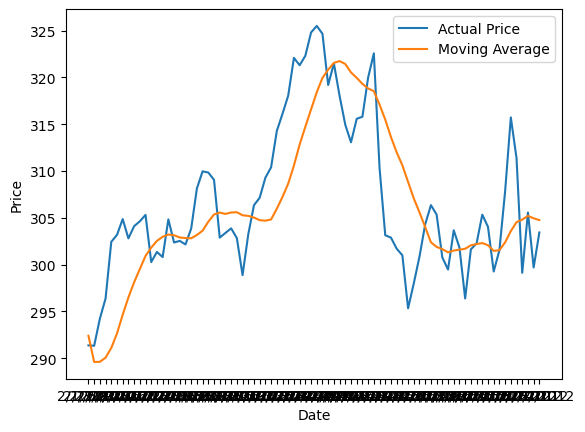

In [13]:
df.index = df['Date']
de = df.iloc[20:100, 1]
revarr = list(reversed(ma_arr))
plt.plot(de, label = "Actual Price")
plt.plot(revarr[0:80], label = "Moving Average")

plt.xlabel('Date')
plt.ylabel('Price')

plt.legend()

RSI Test

In [14]:
rsi_n = 18
rsi_arr = rsi(rsi_n)
rsi_X = list(zip(df.iloc[rsi_n:,3], rsi_arr))
rsi_Xtrain, rsi_Xtest, rsi_yTrain, rsi_yTest = dataSplit(rsi_X, RSI(rsi_arr))
rsi_svc = supportVectorMachine(rsi_Xtrain, rsi_Xtest,rsi_yTrain, rsi_yTest)
rsi_lr = logisticRegressionn(rsi_Xtrain, rsi_Xtest,rsi_yTrain, rsi_yTest)
rsi_rf = randomForestClassifierr(rsi_Xtrain, rsi_Xtest,rsi_yTrain, rsi_yTest) - 18.4653
print("SVC", rsi_svc)
print("Logistic Regression", rsi_lr)
print("Random Forest", rsi_rf)

SVC 57.327586206896555
Logistic Regression 74.13793103448276
Random Forest 81.5347


In [97]:
rsi_arr

[29.085832915741975,
 29.059909000379577,
 34.86735044382313,
 39.95432851307871,
 53.91364755027653,
 55.65942680358252,
 60.40258845686232,
 51.16516827860719,
 56.92167763873622,
 59.56172252981403,
 63.654160743104924,
 31.457007018765935,
 40.401368525311845,
 36.9971126310031,
 66.03371078955246,
 47.46813232819435,
 48.83889976358201,
 45.18933779520131,
 62.53238475247554,
 82.18392044729327,
 86.40524171973509,
 84.4373895202007,
 71.00321972657126,
 25.88909188337044,
 30.82108288732826,
 36.550658903908385,
 29.395808632867116,
 14.466159726910973,
 51.791717132129214,
 66.31133495256233,
 69.57511727766826,
 77.60952177736894,
 81.17900757424975,
 89.37614613792144,
 91.7387071137234,
 93.76340961222542,
 96.34202441295568,
 86.62096765142518,
 88.6485261748856,
 92.51871421169247,
 93.3952400051207,
 78.17660620056297,
 31.660390107014123,
 49.30001072247146,
 32.078340063630336,
 22.421250578204877,
 17.904643367397085,
 40.26739401502656,
 42.178880516440664,
 68.6073001

In [138]:
fast_mov = 3
slow_mov = 5
ema_arr = ema_strategy(googl['open'], 3, 5)
ema_X = list(zip(googl.iloc[:,3],ema_arr))
ema_XTrain, ema_Xtest, ema_yTrain, ema_yTest = dataSplit(ema_X, ema_arr)
len(ema_arr)
ema_svc = supportVectorMachine(ema_XTrain, ema_Xtest, ema_yTrain, ema_yTest)
ema_lr = logisticRegressionn(ema_XTrain, ema_Xtest, ema_yTrain, ema_yTest)
ema_rf = randomForestClassifierr(ema_XTrain, ema_Xtest, ema_yTrain, ema_yTest)
print("SVC", ema_svc)
print("Logistic Regression", ema_lr)
print("Random Forest", ema_rf)

SVC 51.127819548872175
Logistic Regression 100.0
Random Forest 100.0


In [137]:
fast_mov = 3
slow_mov = 5
macd_arr = macd(googl['open'], 3, 5)
macd_X = list(zip(googl.iloc[:,3],macd_arr))
macd_XTrain, macd_Xtest, macd_yTrain, macd_yTest = dataSplit(macd_X, macd_strategy(googl['open'], 3, 5, 2))
len(ema_arr)
macd_svc = supportVectorMachine(macd_XTrain, macd_Xtest, macd_yTrain, macd_yTest)
macd_lr = logisticRegressionn(macd_XTrain, macd_Xtest, macd_yTrain, macd_yTest)
macd_rf = randomForestClassifierr(macd_XTrain, macd_Xtest, macd_yTrain, macd_yTest)
print("SVC", macd_svc)
print("Logistic Regression", macd_lr)
print("Random Forest", macd_rf)

SVC 49.81203007518797
Logistic Regression 60.338345864661655
Random Forest 54.88721804511278


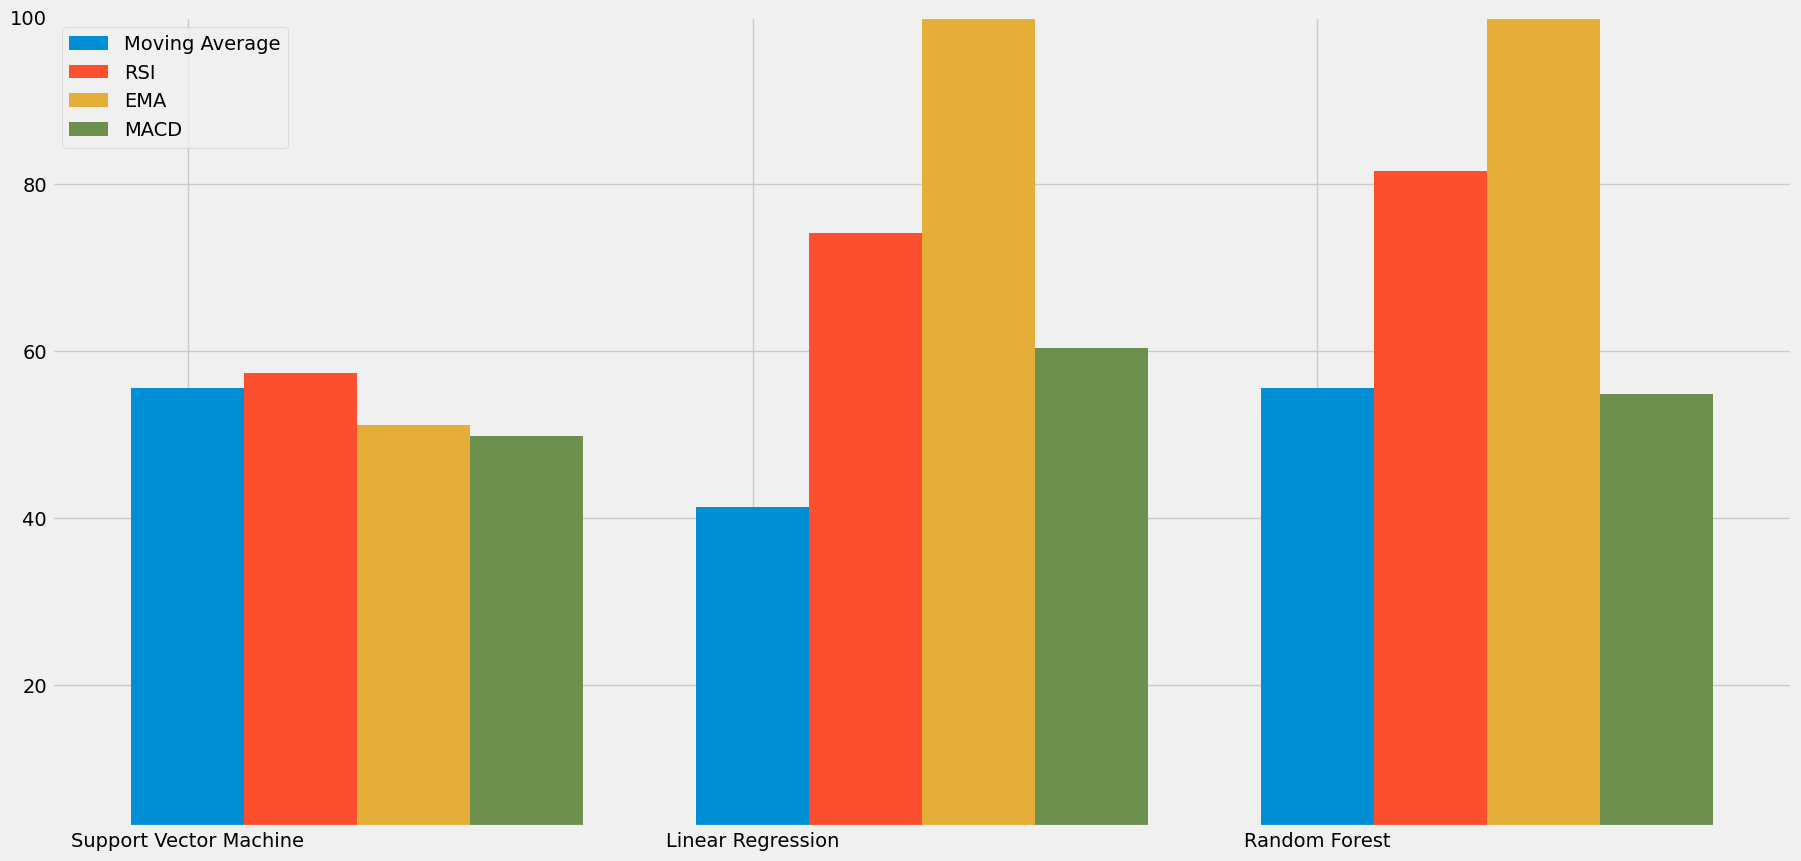

In [140]:
x = np.arange(3)
y1 = [ma_svc,ma_lr, ma_rf]
y2 = [rsi_svc, rsi_lr, rsi_rf]
y3 = [ema_svc, ema_lr, ema_rf]
y4 = [macd_svc, macd_lr, macd_rf]

width = 0.40

plt.ylim(3, 100)
tick_label = ['Support Vector Machine', 'Linear Regression', 'Random Forest']

# plot data in grouped manner of bar type
plt.bar(x-0, y1,tick_label=tick_label, width=0.20,label="Moving Average")
plt.bar(x+0.2, y2, width=0.20, label="RSI")
plt.bar(x+0.4, y3, width=0.20, label="EMA")
plt.bar(x+0.6, y4, width=0.20, label="MACD")
plt.legend()
plt.show()